# Lexical network analysis (2)

## Loading

In [88]:
import importlib
from src.utils.gui import plots_gui as pg
importlib.reload(pg)

<module 'src.utils.gui.plots_gui' from 'c:\\Users\\cyrie\\OneDrive\\Documents\\EPFL\\2025_MA_1\\ADA\\ada-2025-project-adacore42\\src\\utils\\gui\\plots_gui.py'>

In [89]:
### Initialisation of the absolute Github repository path :

from pathlib import Path
import sys

try:
    root = Path(__file__).resolve().parent
except NameError:
    root = Path.cwd()

while root.parent != root:
    if any((root / marker).exists() for marker in [".git", "README.md", "results.ipynb", "README.txt"]):
        break
    root = root.parent

# Fallback in case nothing found
if not any((root / marker).exists() for marker in [".git", "README.md", "results.ipynb", "README.txt"]):
    print("Could not locate project root — defaulting to current working directory")
    root = Path.cwd()

print(f"Root folder detected at: {root}")

# Ensure importability of the project
if str(root) not in sys.path:
    sys.path.insert(0, str(root))


### Import data prepared
from src.utils.paths import STORED_DATAPREP_PKL_PATH, STORED_PLOTSGUI_PKL_PATH, DATA_PREPARATION_PY_PATH, STORED_DATAPREPNOUNS_PKL_PATH, STORED_DATAPREPTOKENS_PKL_PATH, OCCUPATIONS_CSV_PATH
print(f"Data preparation folder detected at: {DATA_PREPARATION_PY_PATH.resolve()}")

Root folder detected at: c:\Users\cyrie\OneDrive\Documents\EPFL\2025_MA_1\ADA\ada-2025-project-adacore42
Data preparation folder detected at: C:\Users\cyrie\OneDrive\Documents\EPFL\2025_MA_1\ADA\ada-2025-project-adacore42\_Other\cycy_analysis\src\data\DataPreparation.py


In [90]:
### Genearal imports

# utils
from src.utils.general_utils import *

# paths
from src.utils.paths import *

# working librairies
import os
import pickle

# classic librairies
import numpy as np
import json
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import pandas as pd
import seaborn as sns
import math


from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from scipy.stats import chi2_contingency, fisher_exact, ttest_ind, mannwhitneyu
from wordcloud import WordCloud
import nltk
from nltk.tokenize import word_tokenize

# --- Embeddings ---
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans


In [91]:
STORED_CLEAN_DATAPREP_PKL_PATH = STORED_MAIN_DIR_PATH / "cleaned_data_prepared.pkl"

# Chargement du fichier pickle
with open(root / STORED_CLEAN_DATAPREP_PKL_PATH, "rb") as f:
    lemmatized_data = pickle.load(f)


### Loading of preprocessed data's pickle :
stored_dataprep_pkl_path = root / STORED_DATAPREP_PKL_PATH

with open(stored_dataprep_pkl_path, "rb") as f:
    data = pickle.load(f)

dataA_lem = lemmatized_data['dataA']
dataC = data['dataC']
dataA_startID = data['dataA_startID']
dataA_endID = data['dataA_endID']
dataC_lastGoodID = data['dataC_lastGoodID']

1) Extraction du dataset pour un contest donné

In [92]:
contest_idx = contest_index2absolute_index(611)

if contest_idx > dataC_lastGoodID:
    print(f"Attention, il n'y a pas de metadonnée pour le contest {contest_idx} !")

contest_data = dataA_lem[contest_idx]
    
df = pd.DataFrame(contest_data)

# Vérifier colonnes
print(df.columns)


Index(['caption', 'mean', 'precision', 'votes', 'not_funny', 'somewhat_funny',
       'funny', 'cleaned_caption'],
      dtype='object')


2) Split : top 10% vs bottom 90%
3) Bag-of-Words + tests statistiques
4) TF-IDF par split
5) Log-Odds Ratio (méthode la plus robuste)
6) Visualisation : Wordcloud pondéré par log-odds
7) Word Embeddings / Similarité sémantique

- On peut soit comparer les mots isolés [ngram_range=(1,1)], soit les n‑grams (2‑3 mots) [(ngram_range=(2,3)] pour capturer les jeux de mots et expressions.

- On calcule les log-odds et TF-IDF sur ces n‑grams pour identifier ce qui est spécifique aux captions drôles.
- Les WordCloud basé sur ces n‑grams permettent de visualiser les résultats.

- le calcul d'embeddings similarity montre si les captions drôles ont des concepts récurrents.

- On regroupe les captions par embeddings (Kmeans clusterisation) pour visualiser les concepts humoristiques.

In [93]:
from src.scripts.axis1 import visualize_caption_analysis, cluster_funny_captions

Top 10% captions: 781, Bottom: 6989
          word       chi2             p
93     adopted  88.151384  6.063194e-21
60      accept  57.002688  4.352166e-14
1455    either  53.950138  2.056426e-13
3388      poor  45.792112  1.314920e-11
1458   elected  44.900922  2.072602e-11
...        ...        ...           ...
5142    youyou   0.000000  1.000000e+00
5143   zealand   0.000000  1.000000e+00
5144      zone   0.000000  1.000000e+00
5145  zootopia   0.000000  1.000000e+00
8         1908   0.000000  1.000000e+00

[5147 rows x 3 columns]


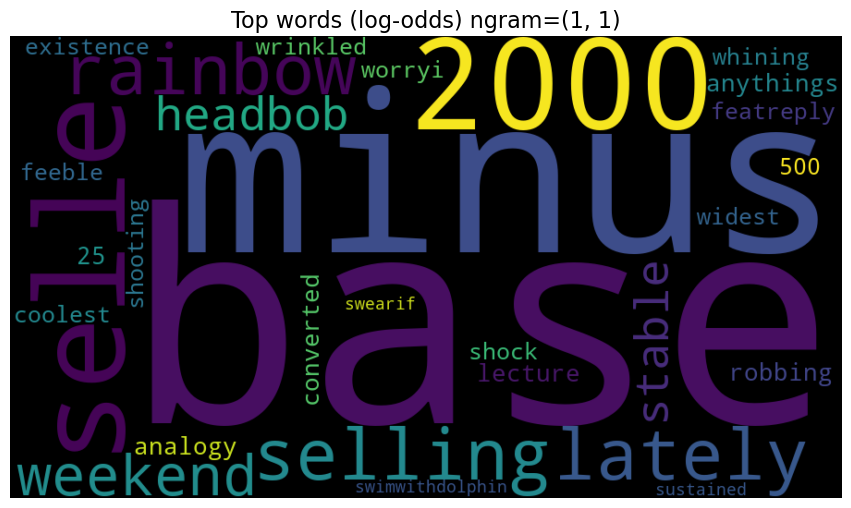

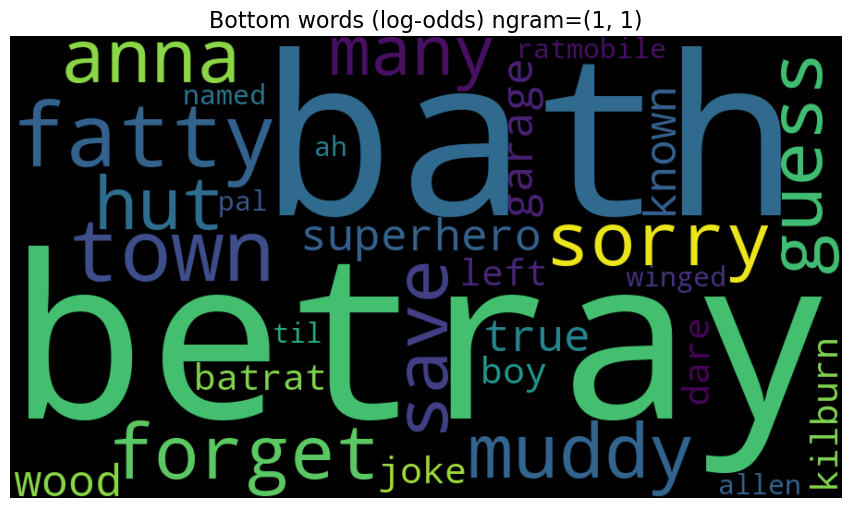

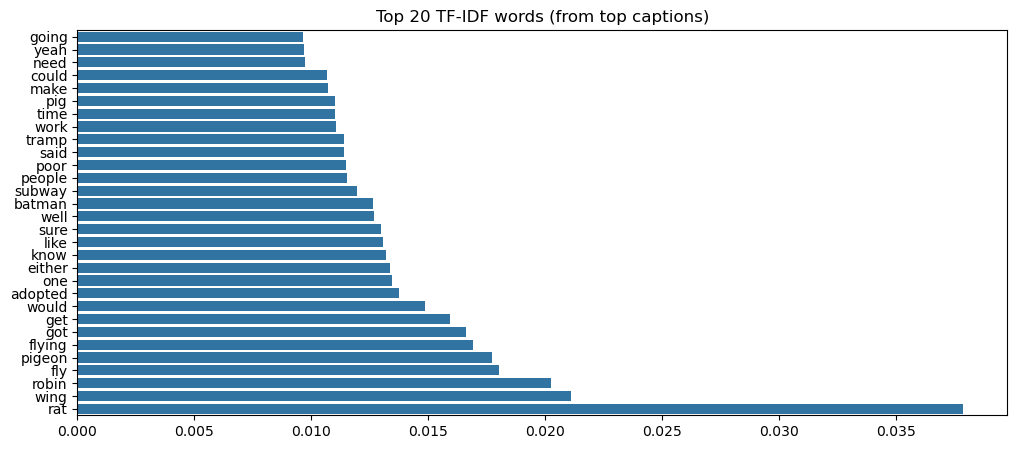

Batches: 100%|██████████| 219/219 [00:30<00:00,  7.21it/s]


Mean sim (top): 0.36689726
Mean sim (bottom): 0.39056775
T-test similarity: -5.769309750964673, p=8.265214933998546e-09


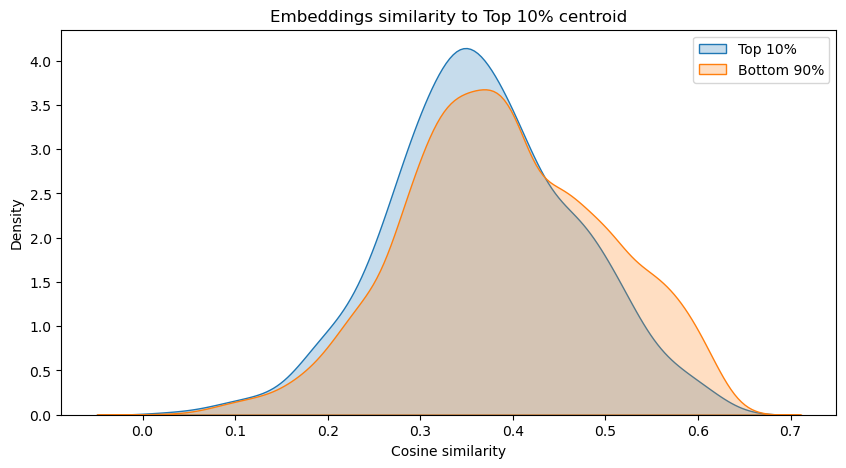

T-test length: 0.03229796028834252, p=0.9742352655961413
Mann-Whitney length: 2800736.0, p=0.2238364223232192


In [94]:
# Unigrams
dict_result_unigrams = visualize_caption_analysis(df, score_col="mean", text_col="cleaned_caption", top_percent=0.1, ngram_range=(1,1))

Top 10% captions: 781, Bottom: 6989
                        word       chi2             p
33488           tell adopted  44.238935  2.906426e-11
11898            get elected  44.238935  2.906426e-11
19766           mean adopted  35.370922  2.725253e-09
25023          president fly  35.370922  2.725253e-09
27981           robin either  30.073052  4.160730e-08
...                      ...        ...           ...
39908         youyou rat bat   0.000000  1.000000e+00
39909      zootopia deserves   0.000000  1.000000e+00
39910  zootopia deserves one   0.000000  1.000000e+00
39911      zootopia inspired   0.000000  1.000000e+00
39912      zuckerberg rescue   0.000000  1.000000e+00

[39913 rows x 3 columns]


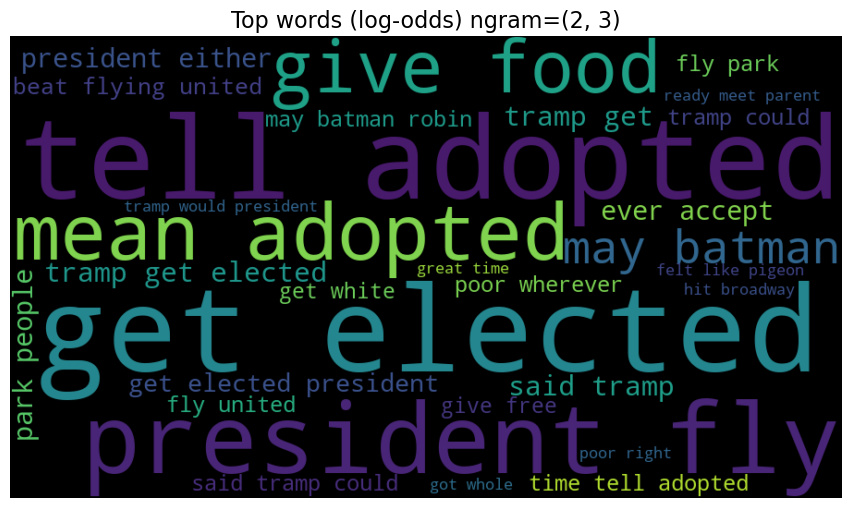

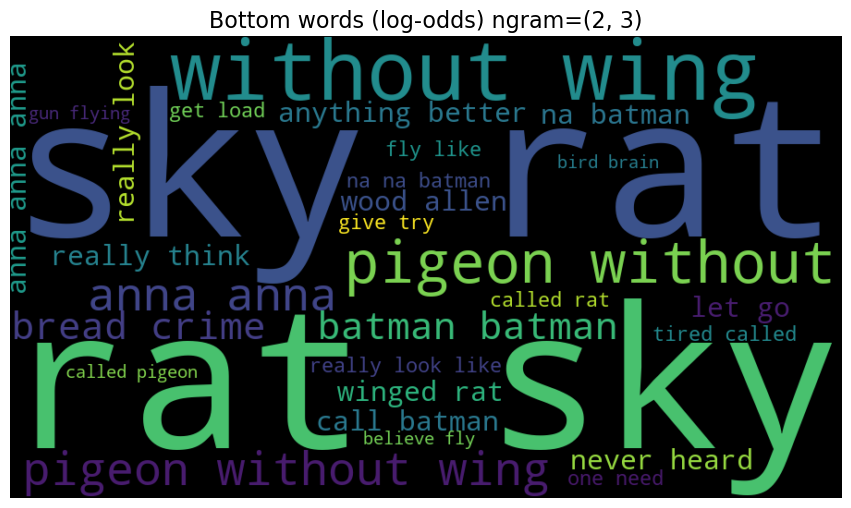

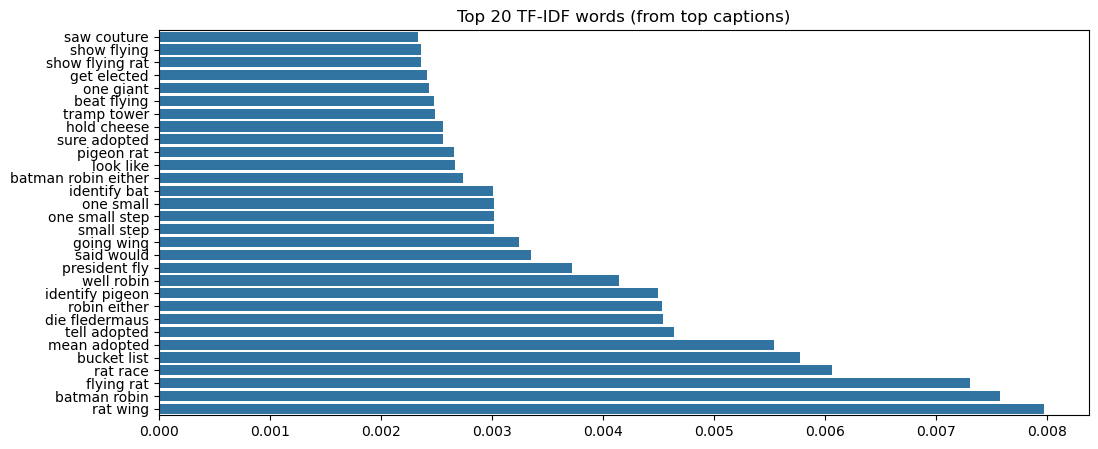

Batches: 100%|██████████| 219/219 [00:43<00:00,  5.09it/s]


Mean sim (top): 0.36689726
Mean sim (bottom): 0.39056775
T-test similarity: -5.769309750964673, p=8.265214933998546e-09


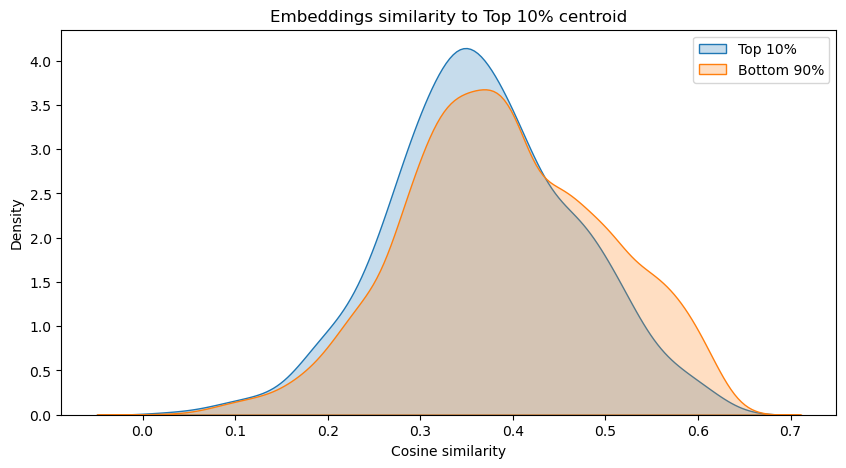

T-test length: 0.03229796028834252, p=0.9742352655961413
Mann-Whitney length: 2800736.0, p=0.2238364223232192


In [95]:
# Bigrams + trigrams
dict_result_bigrams_trigrams = visualize_caption_analysis(df, score_col="mean", text_col="cleaned_caption", top_percent=0.1, ngram_range=(2,3))

Top 10% captions: 781, Bottom: 6989
               word       chi2             p
305         adopted  88.151384  6.063194e-21
160          accept  57.002688  4.352166e-14
5874         either  53.950138  2.056426e-13
16216          poor  45.792112  1.314920e-11
5903        elected  44.900922  2.072602e-11
...             ...        ...           ...
2334      bird suit   0.000000  1.000000e+00
2335      bird sure   0.000000  1.000000e+00
43         2016 pig   0.000000  1.000000e+00
44     2016 primary   0.000000  1.000000e+00
11         11 space   0.000000  1.000000e+00

[25614 rows x 3 columns]


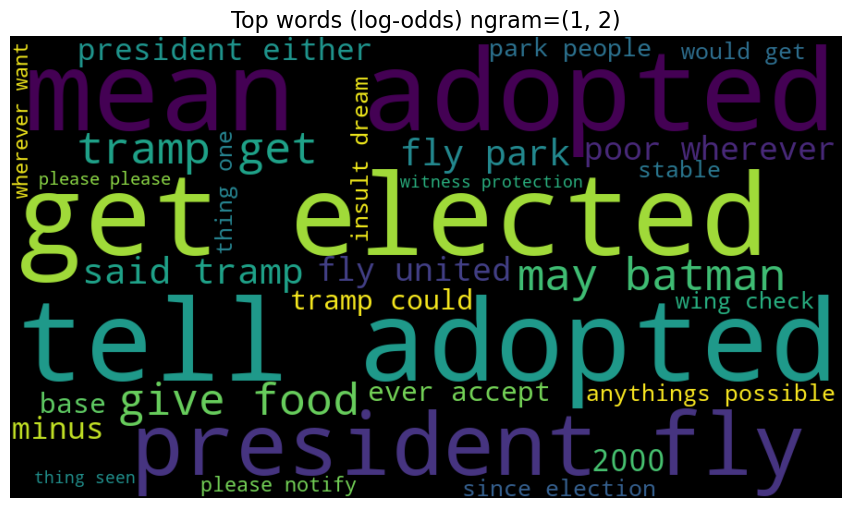

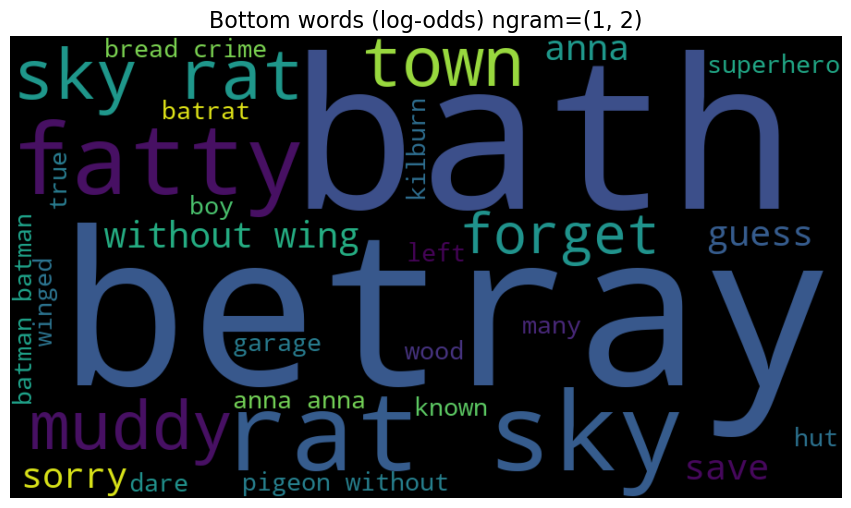

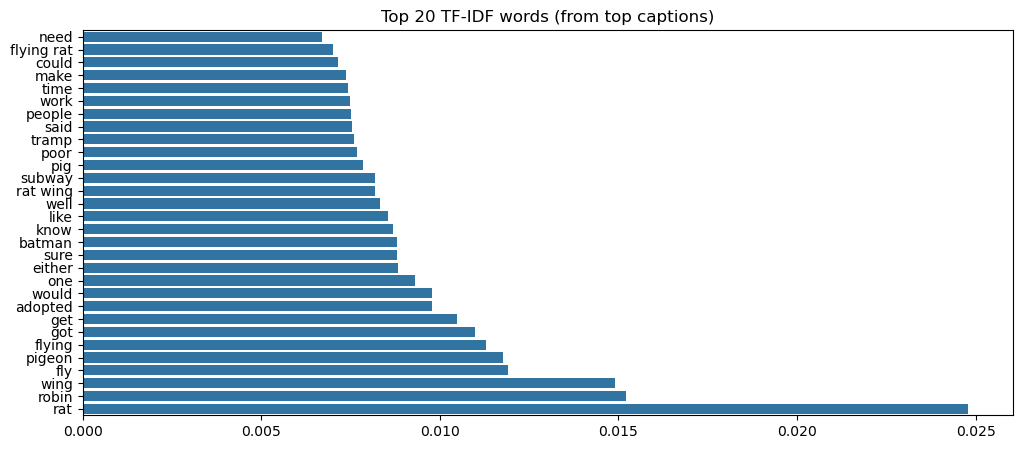

Batches: 100%|██████████| 219/219 [00:32<00:00,  6.66it/s]


Mean sim (top): 0.36689726
Mean sim (bottom): 0.39056775
T-test similarity: -5.769309750964673, p=8.265214933998546e-09


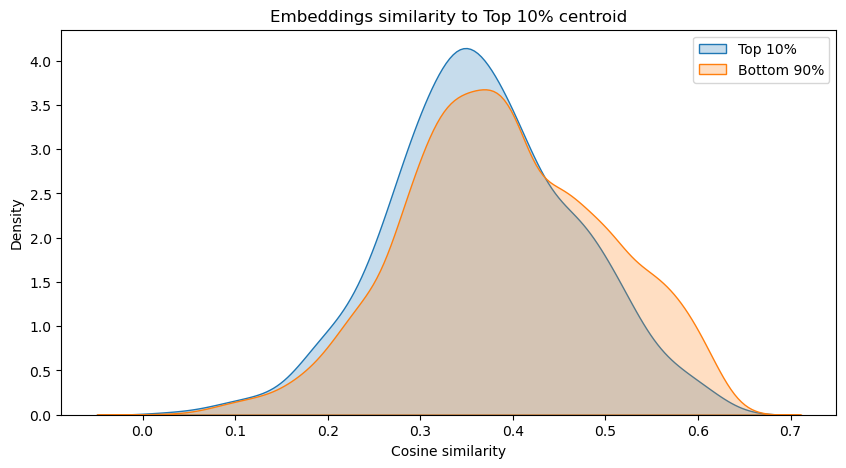

T-test length: 0.03229796028834252, p=0.9742352655961413
Mann-Whitney length: 2800736.0, p=0.2238364223232192


In [96]:
# Unigrams + bigrams
dict_result_unigrams_bigrams = visualize_caption_analysis(df, score_col="mean", text_col="cleaned_caption", top_percent=0.1, ngram_range=(1,2))

Clustering par similarité sémantique → regroupe les captions drôles par thème ou type d’humour.

WordCloud → montre les mots typiques de chaque cluster.

Captions représentatives → les phrases les plus "centrales" dans le cluster, donc très typiques.

Permet de détecter : Jeux de mots sur animaux, Absurdities / incongruité, Références culturelles, Ironie / sarcasme

Selected 781 top captions for clustering.


Batches: 100%|██████████| 25/25 [00:01<00:00, 15.07it/s]


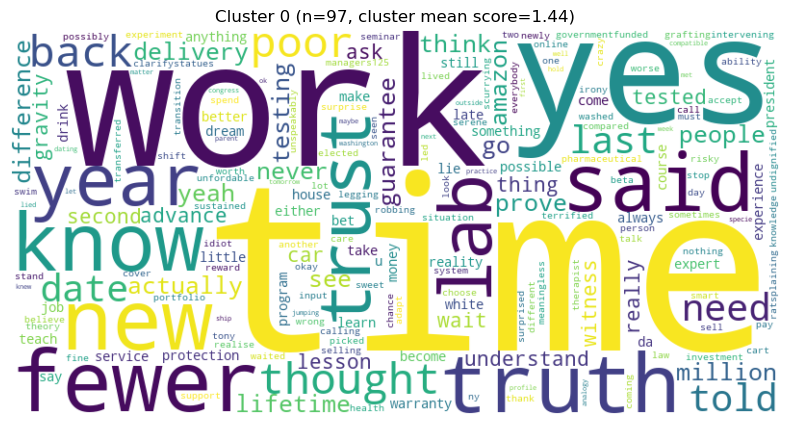

Cluster 0 top representative captions:
 - ok come lifetime guarantee
 - late choose truth
 - second thought take truth
 - time know truth adopted
 - fact even know plan




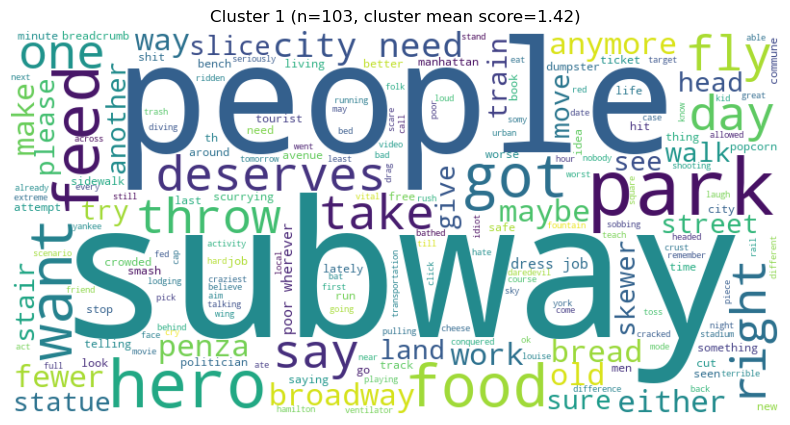

Cluster 1 top representative captions:
 - dream take subway work
 - worse subway
 - ever taken subway
 - please please please work take one subway ride
 - ok walk subway track rush hour




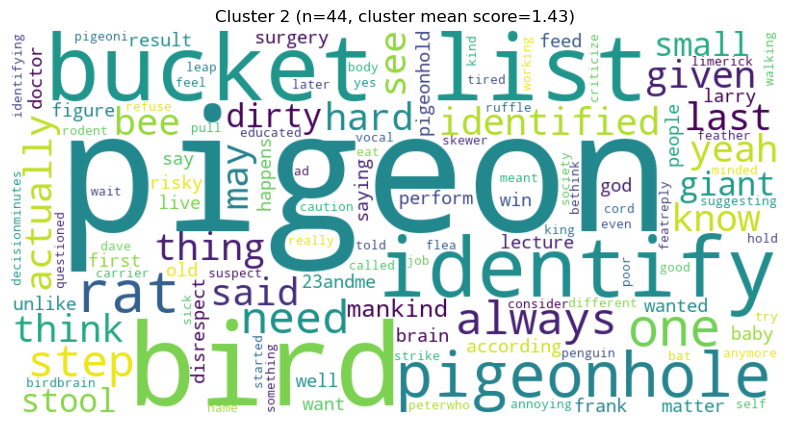

Cluster 2 top representative captions:
 - yeah identify pigeon
 - identify pigeon
 - identify pigeon
 - always identified pigeon
 - think different kind pigeon




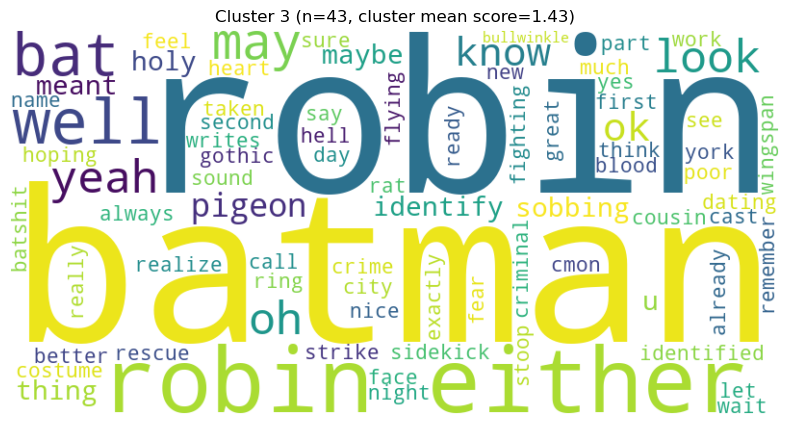

Cluster 3 top representative captions:
 - batman robin
 - batman robin
 - batman robin
 - oh batman well robin
 - realize batman robin either




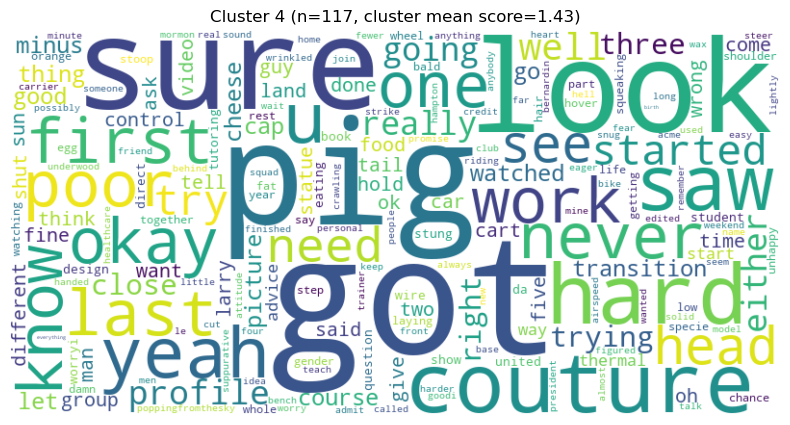

Cluster 4 top representative captions:
 - sure saw pig
 - think got
 - hard
 - hard
 - got idea pig




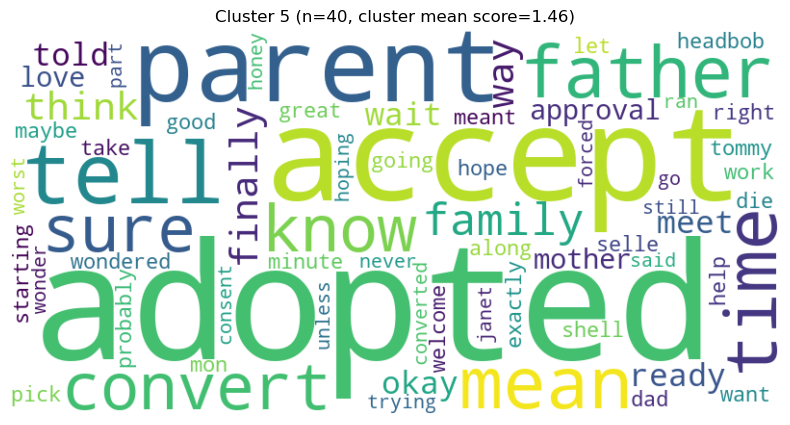

Cluster 5 top representative captions:
 - tell adopted
 - tell adopted
 - wait adopted
 - pick tell adopted
 - would good time tell adopted




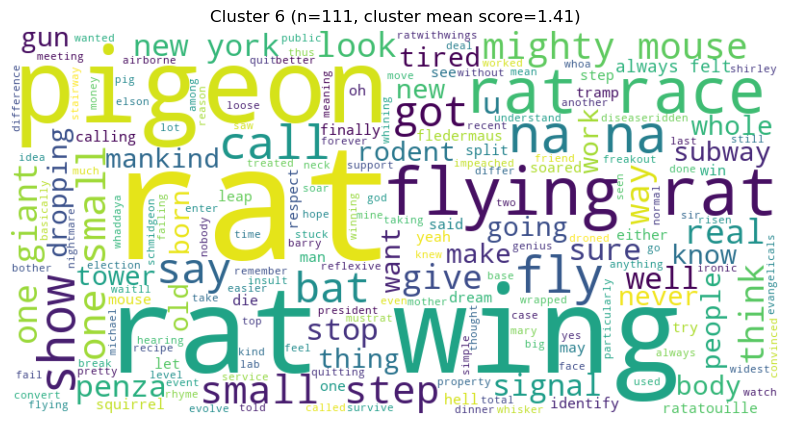

Cluster 6 top representative captions:
 - flying rat
 - flying rat show flying rat
 - show flying rat
 - think flying rat show flying rat
 - call rat wing show rat wing




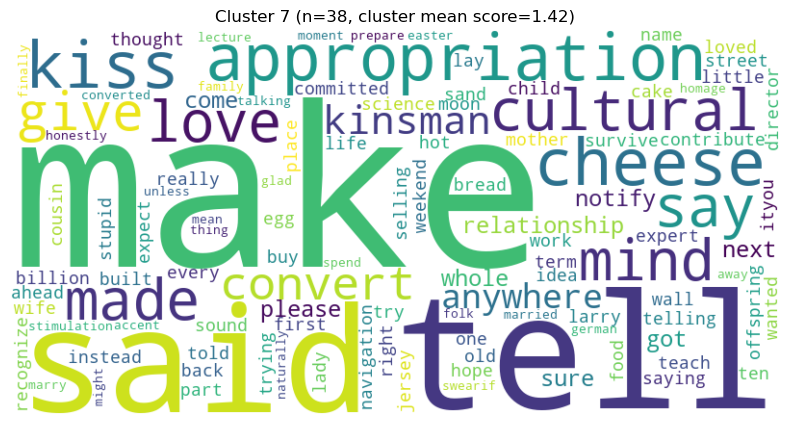

Cluster 7 top representative captions:
 - make tell wife 2000 kiss love
 - make back tell 500 kiss love
 - make tell 758 child love
 - said come naturally
 - finally tell folk converted




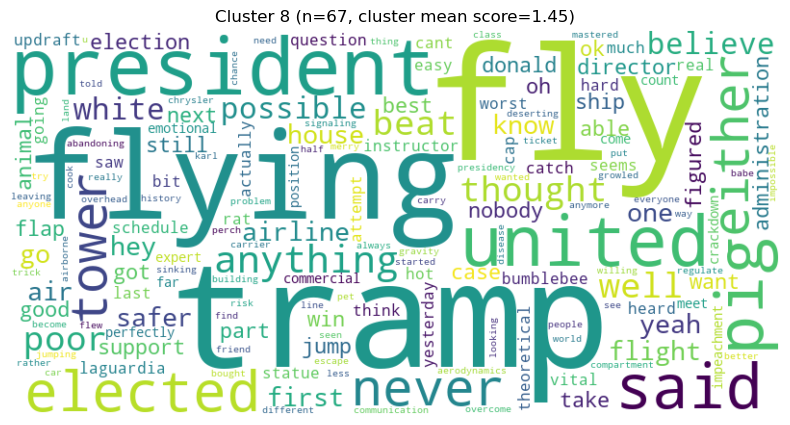

Cluster 8 top representative captions:
 - tramp president fly
 - donald tramp get elected president fly
 - president fly
 - tramp get elected president rat fly
 - could president fly




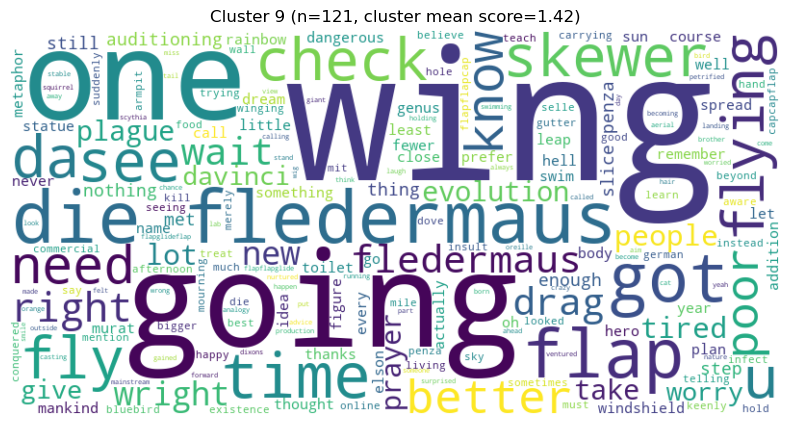

Cluster 9 top representative captions:
 - got wing prayer
 - going wing
 - going wing
 - wing
 - wing




In [104]:
df_top_clustered, summary = cluster_funny_captions(df, text_col="cleaned_caption", score_col="mean", top_percent=0.1, n_clusters=10)

Le mot qui revient le plus dans le cartoon (-> re&collection ? vector embedding ? barplot)
COMPARAISON : Est il present dans la description de l’image ? (-> re&collection ? vector embedding de la description de l’image ?)\
-->	Si oui ok, la blague est attendue, passons\
-->	Si non alors il y a une reference exterieure ! analyser à la main la reference culturelle ou alors utiliser dataset exterieur pour trouver la ref ?